### 1. Import packages

In [1]:
#!conda install --yes -c conda-forge umap-learn
#!pip install umap-learn
#!pip install "umap-learn[plot]"
#!pip install scikit-multilearn
#!pip install imbalanced-learn

In [2]:
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
import sklearn as sk

import sklearn.metrics as metrics
import os

from matplotlib import pyplot
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [3]:
import umap
from umap import UMAP
import plotly.express as px
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats
from statsmodels.formula.api import ols
import random

In [4]:
plt.style.use('ggplot')
import itertools   

In [5]:
import plotly.graph_objects as go
import plotly.express as px

In [6]:
import pickle
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score

In [7]:
import matplotlib.pyplot as plt

In [8]:
#load pickles
with open(r'/Users/momenzadeha/Documents/aneurysm_study/prec_bcorr.pkl', 'rb') as handle:
    prec_bcorr = pickle.load(handle)
with open(r'/Users/momenzadeha/Documents/aneurysm_study/meta_prec.pkl', 'rb') as handle:
    meta_prec = pickle.load(handle)
with open(r'/Users/momenzadeha/Documents/aneurysm_study/prot_bcorr.pkl', 'rb') as handle:
    prot_bcorr = pickle.load(handle)
with open(r'/Users/momenzadeha/Documents/aneurysm_study/meta_prot.pkl', 'rb') as handle:
    meta_prot = pickle.load(handle)

### Peptides Type B (0) vs DTAA (1)

In [9]:
meta_prec1=meta_prec.copy()

In [10]:
meta_prec1.Group.value_counts()

0    75
1    62
2    28
3    24
4    13
Name: Group, dtype: int64

In [11]:
#drop groups 2,3,4
values = [2,3,4]

meta_prec1 = meta_prec1[meta_prec1.Group.isin(values) == False]

In [12]:
meta_prec1.Group.value_counts()

0    75
1    62
Name: Group, dtype: int64

In [13]:
prec_all=prec_bcorr.merge(meta_prec1.Group, left_index=True, right_index=True)

In [14]:
prec1=prec_all.iloc[:,:-1]

In [15]:
prec1.shape

(137, 1468)

In [16]:
meta_prec1.Group.value_counts()

0    75
1    62
Name: Group, dtype: int64

In [ ]:
#hyperparameter optimization on training set
input_dict = {
    'BvsDTAA': prec1}
    
#parameters
Dummy_params = {}

GB_params = {
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [5,50,100],
    'n_estimators':[10,100,500],
    'max_features':['sqrt','log2'],
    'min_samples_leaf': [2, 20, 80, 200, 300],
    'min_samples_split': [2, 20, 80, 200, 300]}

SVC_params = {
    'C': [0.1,1,10,100],
    'kernel':['poly', 'rbf', 'sigmoid'],
    'gamma':[1,0.1,0.01,0.001]}

LR_params = {
    'C':[0.01,0.1,1,10,100],
    'penalty':['l2'],
    'solver':['newton-cg'],
    'max_iter':[100,200,300]}

ET_params = {
    'bootstrap': [True, False],
    'max_depth': [5,50,100],
    'n_estimators':[10,100,500],
    'max_features':['sqrt','log2'],
    'min_samples_leaf': [2, 20, 80, 200, 300],
    'min_samples_split': [2, 20, 80, 200, 300]}

RF_params = {
    'bootstrap': [True, False],
    'max_depth': [5,50,100],
    'n_estimators':[10,100,500],
    'max_features':['sqrt','log2'],
    'min_samples_leaf': [2, 20, 80, 200, 300],
    'min_samples_split': [2, 20, 80, 200, 300]}
           
KNN_params = {
    'leaf_size': [1,5,10,15,20,25,30,35,40,45,50],
    'n_neighbors': [1,5,10,15,20,25,30],
    'p': [1,2]}
    
models_dict = {
    'Dummy': DummyClassifier(random_state=42),
    'GB': GradientBoostingClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'LR': LogisticRegression(random_state=42),
    'ET': ExtraTreesClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier()}

params_dict = {
    'Dummy': Dummy_params,
    'GB':GB_params,
    'SVC':SVC_params,
    'LR':LR_params,
    'ET': ET_params,
    'RF': RF_params,
    'KNN': KNN_params}

#run randomsearch
all_model_dictBvsDTAA = {}
all_F1_dict = {}
all_AUPR_dict = {}

for i in input_dict.keys():
    print('Input:', i)
    temp_1 = {}
    temp_2 = {}
    temp_3 = {}
    Xtrain, Xtest, ytrain, ytest = train_test_split(prec1, meta_prec1.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=meta_prec1.Group) 
    for x in models_dict.keys():
        print(x)
        clf = RandomizedSearchCV(models_dict[x], param_distributions = params_dict[x],
                                 scoring='f1',refit=True, cv=5, n_iter=200, random_state=42)
        clf.fit(Xtrain, ytrain)
        y_predict_proba = clf.predict_proba(Xtrain)[:,1]
        precision, recall, thresholds = precision_recall_curve(ytrain,y_predict_proba)
        print('Best AUPR:',auc(recall, precision))
        print('Best F1:',clf.best_score_)
        print('Best estimator:',clf.best_estimator_)
        temp_1[x] = clf.best_estimator_
        temp_2[x] = clf.best_score_
        temp_3[x] = auc(recall, precision)
    all_model_dictBvsDTAA[i] = temp_1
    all_F1_dict[i] = temp_2
    all_AUPR_dict[i] = temp_3
    
all_F1_df=pd.DataFrame.from_dict(all_F1_dict)
all_AUPR_df=pd.DataFrame.from_dict(all_AUPR_dict)

In [18]:
all_AUPR_df

,BvsDTAA
Dummy,0.724771
ET,1.000000
GB,1.000000
KNN,1.000000
LR,1.000000
RF,0.824773
SVC,1.000000


In [19]:
all_F1_df

,BvsDTAA
Dummy,0.000000
ET,0.588597
GB,0.590803
KNN,0.472220
LR,0.609051
RF,0.593891
SVC,0.608250


In [20]:
#evaluate test set
auroc = {}
fpr = {}
tpr = {}
threshold = {}
AP = {}
prec = {}
f1 = {}
specificity = {}
bal_accuracy = {}
precision = {}
recall1= {}
AUPR = {}
MCC = {}

for x in all_model_dictBvsDTAA.keys():
    temp1 = {}
    temp2 = {}
    temp3 = {}
    temp4 = {} 
    temp5 = {}
    temp6 = {}
    temp7 = {}
    temp8 = {}
    temp9 = {}
    temp10 = {}
    temp11 = {}
    temp12 = {}
    Xtrain, Xtest, ytrain, ytest = train_test_split(prec1, meta_prec1.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=meta_prec1.Group) 
    for y in all_model_dictBvsDTAA[x].keys():
        model = all_model_dictBvsDTAA[x][y]
        ypred = model.predict(Xtest)
        probs = model.predict_proba(Xtest)
        pos_probs = probs[:, 1]
        temp1[y] = roc_auc_score(ytest, pos_probs)
        temp2[y], temp3[y], temp4[y] = roc_curve(ytest, pos_probs)
        temp5[y] = average_precision_score(ytest, ypred)
        temp6[y] = f1_score(ytest, ypred)
        temp7[y] = recall_score(ytest, ypred)
        temp8[y] = balanced_accuracy_score(ytest, ypred)
        temp9[y] = recall_score(ytest, ypred, pos_label=0)
        precision, recall, _ = precision_recall_curve(ytest, pos_probs)
        temp10[y] = auc(recall, precision)
        temp11[y] = matthews_corrcoef(ytest, ypred)
        temp12[y] = precision_score(ytest, ypred,zero_division=0)
    auroc[x] = temp1
    fpr[x] = temp2
    tpr[x] = temp3
    threshold [x] = temp4
    AP[x] = temp5
    f1[x] = temp6
    recall1[x] = temp7
    bal_accuracy[x] = temp8
    specificity[x] = temp9
    AUPR[x] = temp10
    MCC[x] = temp11
    prec[x] = temp12

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


In [21]:
f1=pd.DataFrame.from_dict(f1).rename(columns={'BvsDTAA':'F1'})

In [22]:
AP=pd.DataFrame.from_dict(AP).rename(columns={'BvsDTAA':'AP'})

In [23]:
auroc=pd.DataFrame.from_dict(auroc).rename(columns={'BvsDTAA':'AUROC'})

In [24]:
#recall=sensitivity
recall=pd.DataFrame.from_dict(recall1).rename(columns={'BvsDTAA':'Recall'})

In [25]:
specificity=pd.DataFrame.from_dict(specificity).rename(columns={'BvsDTAA':'Specificity'})

In [26]:
accuracy=pd.DataFrame.from_dict(bal_accuracy).rename(columns={'BvsDTAA':'Bal Accuracy'})

In [27]:
AUPR=pd.DataFrame.from_dict(AUPR).rename(columns={'BvsDTAA':'AUPR'})

In [28]:
MCC=pd.DataFrame.from_dict(MCC).rename(columns={'BvsDTAA':'MCC'})

In [29]:
Precision=pd.DataFrame.from_dict(prec).rename(columns={'BvsDTAA':'Precision'})

In [30]:
pd.concat([f1, AP, Precision, recall, specificity, accuracy, auroc, AUPR, MCC], axis=1)

,F1,AP,Precision,Recall,Specificity,Bal Accuracy,AUROC,AUPR,MCC
Dummy,0.000000,0.464286,0.000000,0.000000,1.000000,0.500000,0.500000,0.732143,0.000000
ET,0.454545,0.499389,0.555556,0.384615,0.733333,0.558974,0.620513,0.651236,0.125954
GB,0.545455,0.557692,0.666667,0.461538,0.800000,0.630769,0.784615,0.796022,0.279290
KNN,0.480000,0.480769,0.500000,0.461538,0.600000,0.530769,0.530769,0.605769,0.062017
LR,0.592593,0.530220,0.571429,0.615385,0.600000,0.607692,0.630769,0.571109,0.214834
RF,0.470588,0.629121,1.000000,0.307692,1.000000,0.653846,0.620513,0.698206,0.438529
SVC,0.545455,0.557692,0.666667,0.461538,0.800000,0.630769,0.676923,0.539989,0.279290


In [31]:
no_skill = len(ytest[ytest==1]) / len(ytest)
no_skill

0.4642857142857143

### Proteins Type B (0) vs DTAA (1)

In [32]:
meta_prot1=meta_prot.copy()

In [33]:
meta_prot1.Group.value_counts()

0    75
1    62
2    28
3    24
4    13
Name: Group, dtype: int64

In [34]:
#drop groups 2,3,4
values = [2,3,4]

meta_prot1 = meta_prot1[meta_prot1.Group.isin(values) == False]

In [35]:
meta_prot1.Group.value_counts()

0    75
1    62
Name: Group, dtype: int64

In [36]:
prot_all=prot_bcorr.merge(meta_prot1.Group, left_index=True, right_index=True)

In [37]:
prot1=prot_all.iloc[:,:-1]

In [38]:
prot1.shape

(137, 195)

In [39]:
meta_prot1.Group.value_counts()

0    75
1    62
Name: Group, dtype: int64

In [40]:
#hyperparameter optimization on training set
input_dict = {
    'protBvsDTAA': prot1}
    
#parameters
Dummy_params = {}

GB_params = {
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [5,50,100],
    'n_estimators':[10,100,500],
    'max_features':['sqrt','log2'],
    'min_samples_leaf': [2, 20, 80, 200, 300],
    'min_samples_split': [2, 20, 80, 200, 300]}

SVC_params = {
    'C': [0.1,1,10,100],
    'kernel':['poly', 'rbf', 'sigmoid'],
    'gamma':[1,0.1,0.01,0.001]}

LR_params = {
    'C':[0.01,0.1,1,10,100],
    'penalty':['l2'],
    'solver':['newton-cg'],
    'max_iter':[100,200,300]}

ET_params = {
    'bootstrap': [True, False],
    'max_depth': [5,50,100],
    'n_estimators':[10,100,500],
    'max_features':['sqrt','log2'],
    'min_samples_leaf': [2, 20, 80, 200, 300],
    'min_samples_split': [2, 20, 80, 200, 300]}

RF_params = {
    'bootstrap': [True, False],
    'max_depth': [5,50,100],
    'n_estimators':[10,100,500],
    'max_features':['sqrt','log2'],
    'min_samples_leaf': [2, 20, 80, 200, 300],
    'min_samples_split': [2, 20, 80, 200, 300]}
           
KNN_params = {
    'leaf_size': [1,5,10,15,20,25,30,35,40,45,50],
    'n_neighbors': [1,5,10,15,20,25,30],
    'p': [1,2]}
    
models_dict = {
    'Dummy': DummyClassifier(random_state=42),
    'GB': GradientBoostingClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'LR': LogisticRegression(random_state=42),
    'ET': ExtraTreesClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier()}

params_dict = {
    'Dummy': Dummy_params,
    'GB':GB_params,
    'SVC':SVC_params,
    'LR':LR_params,
    'ET': ET_params,
    'RF': RF_params,
    'KNN': KNN_params}

#run randomsearch
all_model_dictprotBvsDTAA = {}
all_F1_dict = {}
all_AUPR_dict = {}

for i in input_dict.keys():
    print('Input:', i)
    temp_1 = {}
    temp_2 = {}
    temp_3 = {}
    Xtrain, Xtest, ytrain, ytest = train_test_split(prot1, meta_prot1.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=meta_prot1.Group) 
    for x in models_dict.keys():
        print(x)
        clf = RandomizedSearchCV(models_dict[x], param_distributions = params_dict[x],
                                 scoring='f1',refit=True, cv=5, n_iter=200, random_state=42)
        clf.fit(Xtrain, ytrain)
        y_predict_proba = clf.predict_proba(Xtrain)[:,1]
        precision, recall, thresholds = precision_recall_curve(ytrain,y_predict_proba)
        print('Best AUPR:',auc(recall, precision))
        print('Best F1:',clf.best_score_)
        print('Best estimator:',clf.best_estimator_)
        temp_1[x] = clf.best_estimator_
        temp_2[x] = clf.best_score_
        temp_3[x] = auc(recall, precision)
    all_model_dictprotBvsDTAA[i] = temp_1
    all_F1_dict[i] = temp_2
    all_AUPR_dict[i] = temp_3
    
all_F1_df=pd.DataFrame.from_dict(all_F1_dict)
all_AUPR_df=pd.DataFrame.from_dict(all_AUPR_dict)

Input: protBvsDTAA
Dummy
Best AUPR: 0.7247706422018348
Best F1: 0.0
Best estimator: DummyClassifier(random_state=42)
GB


The total space of parameters 1 is smaller than n_iter=200. Running 1 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.5824590888987173
Best estimator: GradientBoostingClassifier(learning_rate=1, max_depth=50, max_features='sqrt',
                           min_samples_leaf=2, n_estimators=10,
                           random_state=42)
SVC


The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.5803356216628528
Best estimator: SVC(C=10, gamma=0.01, probability=True, random_state=42)
LR


The total space of parameters 15 is smaller than n_iter=200. Running 15 iterations. For exhaustive searches, use GridSearchCV.
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line sear

Best AUPR: 1.0
Best F1: 0.5702373581011352
Best estimator: LogisticRegression(C=1, random_state=42, solver='newton-cg')
ET
Best AUPR: 0.9496173757038997
Best F1: 0.5297937356760886
Best estimator: ExtraTreesClassifier(max_depth=50, max_features='log2', min_samples_leaf=2,
                     min_samples_split=20, n_estimators=10, random_state=42)
RF
Best AUPR: 0.9993915933720429
Best F1: 0.6492053663570692
Best estimator: RandomForestClassifier(max_depth=100, max_features='log2', min_samples_leaf=2,
                       n_estimators=10, random_state=42)
KNN


The total space of parameters 154 is smaller than n_iter=200. Running 154 iterations. For exhaustive searches, use GridSearchCV.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behav

Best AUPR: 0.7732635159326888
Best F1: 0.5268525592055003
Best estimator: KNeighborsClassifier(leaf_size=1, p=1)


In [41]:
all_AUPR_df

,protBvsDTAA
Dummy,0.724771
ET,0.949617
GB,1.000000
KNN,0.773264
LR,1.000000
RF,0.999392
SVC,1.000000


In [121]:
all_F1_df

,protBvsDTAA
Dummy,0.000000
ET,0.529794
GB,0.582459
KNN,0.526853
LR,0.570237
RF,0.649205
SVC,0.580336


In [122]:
#evaluate test set
auroc = {}
fpr = {}
tpr = {}
threshold = {}
AP = {}
f1 = {}
specificity = {}
bal_accuracy = {}
precision = {}
recall1= {}
AUPR = {}
MCC = {}
prec = {}

for x in all_model_dictprotBvsDTAA.keys():
    temp1 = {}
    temp2 = {}
    temp3 = {}
    temp4 = {} 
    temp5 = {}
    temp6 = {}
    temp7 = {}
    temp8 = {}
    temp9 = {}
    temp10 = {}
    temp11 = {}
    Xtrain, Xtest, ytrain, ytest = train_test_split(prot1, meta_prot1.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=meta_prot1.Group) 
    for y in all_model_dictprotBvsDTAA[x].keys():
        model = all_model_dictprotBvsDTAA[x][y]
        ypred = model.predict(Xtest)
        probs = model.predict_proba(Xtest)
        pos_probs = probs[:, 1]
        temp1[y] = roc_auc_score(ytest, pos_probs)
        temp2[y], temp3[y], temp4[y] = roc_curve(ytest, pos_probs)
        temp5[y] = average_precision_score(ytest, ypred)
        temp6[y] = f1_score(ytest, ypred)
        temp7[y] = recall_score(ytest, ypred)
        temp8[y] = balanced_accuracy_score(ytest, ypred)
        temp9[y] = recall_score(ytest, ypred, pos_label=0)
        precision, recall, _ = precision_recall_curve(ytest, pos_probs)
        temp10[y] = auc(recall, precision)
        temp11[y] = matthews_corrcoef(ytest, ypred)
    auroc[x] = temp1
    fpr[x] = temp2
    tpr[x] = temp3
    threshold [x] = temp4
    AP[x] = temp5
    f1[x] = temp6
    recall1[x] = temp7
    bal_accuracy[x] = temp8
    specificity[x] = temp9
    AUPR[x] = temp10
    MCC[x]=temp11
    prec[x]=temp12

In [123]:
f1=pd.DataFrame.from_dict(f1).rename(columns={'protBvsDTAA':'F1'})

In [124]:
AP=pd.DataFrame.from_dict(AP).rename(columns={'protBvsDTAA':'AP'})

In [125]:
auroc=pd.DataFrame.from_dict(auroc).rename(columns={'protBvsDTAA':'AUROC'})

In [126]:
#recall=sensitivity
recall=pd.DataFrame.from_dict(recall1).rename(columns={'protBvsDTAA':'Recall'})

In [127]:
specificity=pd.DataFrame.from_dict(specificity).rename(columns={'protBvsDTAA':'Specificity'})

In [128]:
accuracy=pd.DataFrame.from_dict(bal_accuracy).rename(columns={'protBvsDTAA':'Bal Accuracy'})

In [129]:
AUPR=pd.DataFrame.from_dict(AUPR).rename(columns={'protBvsDTAA':'AUPR'})

In [130]:
MCC=pd.DataFrame.from_dict(MCC).rename(columns={'protBvsDTAA':'MCC'})

In [131]:
pd.concat([f1, AP, recall, specificity, accuracy, auroc, AUPR, MCC], axis=1)

,F1,AP,Recall,Specificity,Bal Accuracy,AUROC,AUPR,MCC
Dummy,0.000000,0.464286,0.000000,1.000000,0.500000,0.500000,0.732143,0.000000
ET,0.444444,0.567582,0.307692,0.933333,0.620513,0.651282,0.679118,0.313857
GB,0.400000,0.497253,0.307692,0.800000,0.553846,0.641026,0.624175,0.124035
KNN,0.416667,0.460539,0.384615,0.600000,0.492308,0.551282,0.555426,-0.015710
LR,0.785714,0.691941,0.846154,0.733333,0.789744,0.753846,0.710963,0.579487
RF,0.720000,0.662088,0.692308,0.800000,0.746154,0.748718,0.766255,0.496139
SVC,0.583333,0.556943,0.538462,0.733333,0.635897,0.779487,0.750187,0.277548


In [132]:
no_skill = len(ytest[ytest==1]) / len(ytest)
no_skill

0.4642857142857143

### Overlayed AUPR Curves

In [261]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(10,9)})

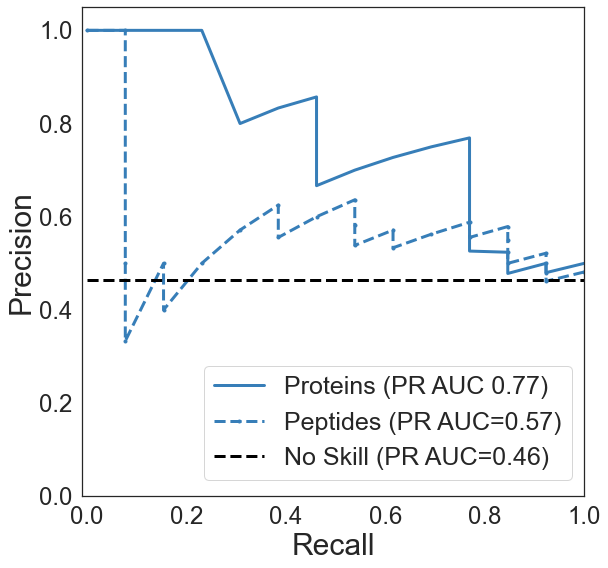

In [317]:
#Type B vs DTAA proteins
model = all_model_dictprotBvsDTAA['protBvsDTAA']['RF']
Xtrain, Xtest, ytrain, ytest = train_test_split(prot1, meta_prot1.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=meta_prot1.Group) 
ypred = model.predict(Xtest)
probs = model.predict_proba(Xtest)
pos_probs = probs[:, 1]
precision, recall, _ = precision_recall_curve(ytest, pos_probs)
pyplot.plot(recall, precision, linewidth=3, color='#377eb8',
            label='Proteins (PR AUC 0.77)')

#Type B vs DTAA peptides
model = all_model_dictBvsDTAA['BvsDTAA']['LR']
Xtrain, Xtest, ytrain, ytest = train_test_split(prec1, meta_prec1.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=meta_prec1.Group) 
ypred = model.predict(Xtest)
probs = model.predict_proba(Xtest)
pos_probs = probs[:, 1]
precision, recall, _ = precision_recall_curve(ytest, pos_probs)
pyplot.plot(recall, precision, marker='.', linewidth=3, color='#377eb8',
            label='Peptides (PR AUC=0.57)', linestyle='--')

#no skill line
no_skill = len(ytest[ytest==1]) / len(ytest)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', linewidth=3, color='black',
            label='No Skill (PR AUC=0.46)')

# axis labels
pyplot.xlabel('Recall', fontsize=30)
pyplot.ylabel('Precision', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim([-0.01, 1])
plt.ylim([0.0, 1.05])

pyplot.legend(fontsize=25, loc='right', bbox_to_anchor=(1, 0.15))
plt.savefig('AUPRBvDTAA.svg',bbox_inches='tight')
pyplot.show()

### Scatterplot Type B vs DTAA - F1 vs MCC

In [1]:
data = {'MCC': [0, 0.125954, 0.279290, 0.438529, 0.279290,0.062017, 0.214834,
               0, 0.313857, 0.124035, 0.496139, 0.277548,-0.015710, 0.579487],
        'F1': [0, 0.454545, 0.545455, 0.470588, 0.545455,0.48, 0.592593,
              0, 0.444444, 0.400000, 0.720000, 0.583333, 0.416667, 0.785714],
        'Type': ['Peptide','Peptide','Peptide','Peptide','Peptide','Peptide','Peptide',
                'Protein','Protein','Protein','Protein','Protein','Protein','Protein'],
        'Model': ['Dummy','ET','GB','RF','SVC','KNN','LR',
                 'Dummy','ET','GB','RF','SVC','KNN','LR']}

In [5]:
BvDTAA = pd.DataFrame(data)

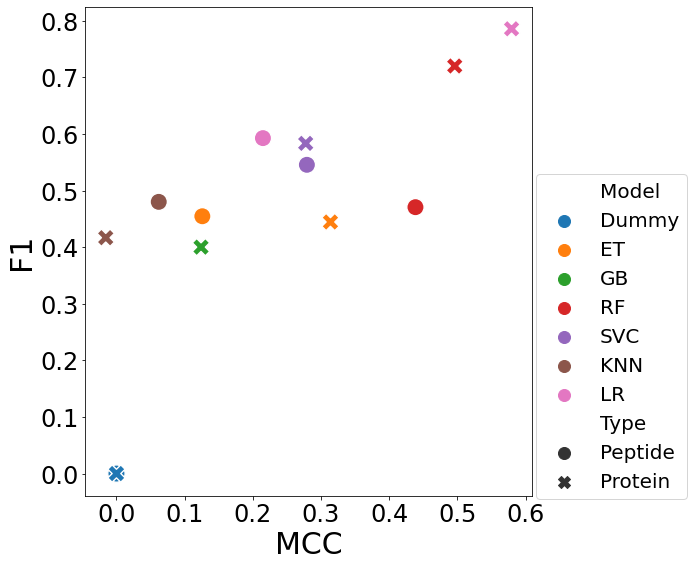

In [6]:
plt.rcParams['figure.figsize']=8,9
ax=sns.scatterplot(data=BvDTAA, x="MCC", y="F1", hue="Model", style="Type", s=300)
ax.legend(fontsize=20, bbox_to_anchor=(1.37, 0.325), loc='center right',markerscale=2)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('F1', fontsize=30)
plt.xlabel('MCC', fontsize=30)
#ax.set_title("TypeB vs DTAA - All Peptides vs All Proteins", fontsize=24)
plt.savefig('MCCvsF1_BvDTAA.svg',bbox_inches='tight')